# Test model

In [1]:
from keras.models import model_from_json
from pickle import dump, load
import matplotlib.pyplot as plt
from keras.preprocessing.sequence import pad_sequences
import numpy as np
from nltk.translate.bleu_score import sentence_bleu

Using TensorFlow backend.


In [2]:
images = '../../datasets/flickr8k/Flicker8k_Dataset/'
max_length=34

In [3]:
def list_of_lists(lst): 
    res = [] 
    for el in lst: 
        sub = el.split(', ') 
        res.append(sub) 
      
    return(res) 


In [4]:
def plot_image(filename):
    x=plt.imread(filename)
    plt.imshow(x)
    plt.show()

In [5]:
def load_descriptions(filename):
    file = open(filename, 'r')
    doc = file.read()
    file.close()
    
    mapping = dict()
    for line in doc.split('\n'):
        tokens = line.split()
        if len(line) < 2:
            continue
        image_id, image_desc = tokens[0], tokens[1:]
        image_id = image_id.split('.')[0]
        image_desc = ' '.join(image_desc)
        if image_id not in mapping:
            mapping[image_id] = list()
        mapping[image_id].append(image_desc)
    return mapping

In [6]:
def load_model(filename, verbose=False):
    json_file = open(filename + '.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    loaded_model.load_weights(filename + ".h5")
    if verbose:
        print("The following model " + filename + " has been loaded")
    return loaded_model

In [7]:
def greedySearch(photo):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
#         print(sequence)
        sequence = pad_sequences([sequence], maxlen=max_length)
#         print(sequence)
        yhat = model.predict([photo,sequence], verbose=0)
#         print(yhat)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

### Load necessary data

In [8]:
with open("./encoded_test_images.pkl", "rb") as encoded_pickle:
    encoding_test = load(encoded_pickle)

In [9]:
with open("./wordtoix.pkl", "rb") as encoded_pickle:
    wordtoix = load(encoded_pickle)

In [10]:
with open("./ixtoword.pkl", "rb") as encoded_pickle:
    ixtoword = load(encoded_pickle)

### Load model

In [16]:
model = load_model('./model_weights/model_lstm2_9')

# Evaluate model on test set

In [17]:
test_descriptions = load_descriptions('test_captions.txt')
total_score_1 = 0
total_score_2 = 0
total_score_3 = 0
total_score_4 = 0

for index in range(len(encoding_test)):
    image_name = list(encoding_test.keys())[index]
    image_feature_vector = encoding_test[image_name].reshape((1,2048))
    candidate = greedySearch(image_feature_vector)

    reference =[]
    for l in list_of_lists(test_descriptions[image_name[:-4]]):
        reference.append(l[0].split()[1:-1])
    candidate = candidate.split()
    
    score_1 = sentence_bleu(reference, candidate,weights=(1, 0, 0, 0))
    score_2 = sentence_bleu(reference, candidate,weights=(0.5, 0.5, 0, 0))
    score_3 = sentence_bleu(reference, candidate,weights=(0.33, 0.33, 0.33, 0))
    score_4 = sentence_bleu(reference, candidate,weights=(0.25, 0.25, 0.25, 0.25))
    
    total_score_1+=score_1
    total_score_2+=score_2
    total_score_3+=score_3
    total_score_4+=score_4
    
print("Average score_1: ", total_score_1/len(encoding_test))
print("Average score_2: ", total_score_2/len(encoding_test))
print("Average score_3: ", total_score_3/len(encoding_test))
print("Average score_4: ", total_score_4/len(encoding_test))

Average score_1:  0.4301916944482716
Average score_2:  0.20219345290039253
Average score_3:  0.0764549221745076
Average score_4:  0.024913765619884447


In [ ]:
# lstm_2_3
Average score_1:  0.450796965838015
Average score_2:  0.2194251982754864
Average score_3:  0.08803222577889473
Average score_4:  0.03127595739584194

In [ ]:
Average score_1:  0.4426515290637138
Average score_2:  0.22533503119076684
Average score_3:  0.08621762269388877
Average score_4:  0.023887468110512393

### Evaluate one image

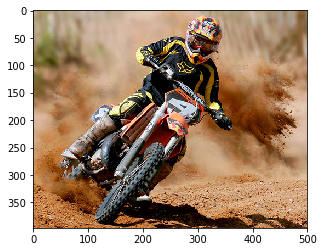

Score:  0.596559544542913
Description:  ['dirt', 'bike', 'rider', 'is', 'riding', 'bike', 'on', 'dirt', 'bike']
Reference descriptions:  ['startseq dirt biker turns across the dirt endseq', 'startseq dirt bike takes turn endseq', 'startseq man riding motorbike kicks up dirt endseq', 'startseq person rides dirt bike endseq', 'startseq the motorcycle racer is taking curve on the dirt track endseq']


In [149]:
index=1
image_name = list(encoding_test.keys())[index]
image_feature_vector = encoding_test[image_name].reshape((1,2048))
candidate = greedySearch(image_feature_vector)

reference =[]
for l in list_of_lists(test_descriptions[image_name[:-4]]):
    reference.append(l[0].split()[1:-1])
candidate = candidate.split()
score = sentence_bleu(reference, candidate,weights=(1, 0, 0, 0))

plot_image(images+image_name)
print("Score: ", score)
print("Description: ", candidate)
print("Reference descriptions: ", test_descriptions[image_name[:-4]])

# Evaluate model with lematized sentenses

In [106]:
import nltk
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/i322062/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [111]:
from nltk.corpus import wordnet

def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

In [112]:
# lemma_captions = load_descriptions('lemma_captions.txt')

In [137]:
def lemmatize_sentense(sentence):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in nltk.word_tokenize(sentence)]

In [154]:
test_descriptions = load_descriptions('test_captions.txt')
total_score_1 = 0
total_score_2 = 0
total_score_3 = 0
total_score_4 = 0

for index in range(len(encoding_test)):
    image_name = list(encoding_test.keys())[index]
    image_feature_vector = encoding_test[image_name].reshape((1,2048))
    candidate = greedySearch(image_feature_vector)

    reference =[]
    for l in list_of_lists(test_descriptions[image_name[:-4]]):
        reference.append(l[0].split()[1:-1])
    candidate = candidate.split()
    candidate = lemmatize_sentense(' '.join(candidate))
    ref = []
    for elem in reference:
        ref.append(lemmatize_sentense(' '.join(elem)))
    
    score_1 = sentence_bleu(ref, candidate,weights=(1, 0, 0, 0))
    score_2 = sentence_bleu(ref, candidate,weights=(0.5, 0.5, 0, 0))
    score_3 = sentence_bleu(ref, candidate,weights=(0.33, 0.33, 0.33, 0))
    score_4 = sentence_bleu(ref, candidate,weights=(0.25, 0.25, 0.25, 0.25))
    
    total_score_1+=score_1
    total_score_2+=score_2
    total_score_3+=score_3
    total_score_4+=score_4
    
print("Average score_1: ", total_score_1/len(encoding_test))
print("Average score_2: ", total_score_2/len(encoding_test))
print("Average score_3: ", total_score_3/len(encoding_test))
print("Average score_4: ", total_score_4/len(encoding_test))

Average score_1:  0.4642805889852785
Average score_2:  0.2282949076475538
Average score_3:  0.08232767358492882
Average score_4:  0.02838331934487361


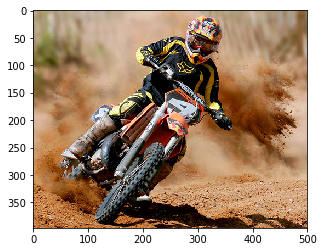

Score:  0.596559544542913
Description:  ['dirt', 'bike', 'rider', 'be', 'rid', 'bike', 'on', 'dirt', 'bike']
Reference descriptions:  [['dirt', 'biker', 'turn', 'across', 'the', 'dirt'], ['dirt', 'bike', 'take', 'turn'], ['man', 'rid', 'motorbike', 'kick', 'up', 'dirt'], ['person', 'ride', 'dirt', 'bike'], ['the', 'motorcycle', 'racer', 'be', 'take', 'curve', 'on', 'the', 'dirt', 'track']]


In [146]:
index=1
image_name = list(encoding_test.keys())[index]
image_feature_vector = encoding_test[image_name].reshape((1,2048))
candidate = greedySearch(image_feature_vector)

reference =[]
for l in list_of_lists(test_descriptions[image_name[:-4]]):
    reference.append(l[0].split()[1:-1])
candidate = candidate.split()
candidate = lemmatize_sentense(' '.join(candidate))
ref = []
for elem in reference:
    ref.append(lemmatize_sentense(' '.join(elem)))
score = sentence_bleu(ref, candidate,weights=(1, 0, 0, 0))

plot_image(images+image_name)
print("Score: ", score)
print("Description: ", candidate)
print("Reference descriptions: ", ref)